<a id="toc"></a>

# <u>Table of Contents</u>

1.) [Setup](#setup)  
&nbsp;&nbsp;&nbsp;&nbsp; 1.1.) [Standard Imports](#imports)   
&nbsp;&nbsp;&nbsp;&nbsp; 1.2.) [Visualization Imports](#imports)   
&nbsp;&nbsp;&nbsp;&nbsp; 1.3.) [Helpers](#helpers)   
&nbsp;&nbsp;&nbsp;&nbsp; 1.4.) [Load data](#load)   
2.) [General Overview](#general)  
&nbsp;&nbsp;&nbsp;&nbsp; 2.1.) [Timezone](#timezone)   
&nbsp;&nbsp;&nbsp;&nbsp; 2.2.) [Oldest Transcript](#oldest)   
&nbsp;&nbsp;&nbsp;&nbsp; 2.3.) [5 Oldest Stories](#old_5)   
&nbsp;&nbsp;&nbsp;&nbsp; 2.4.) [Date spread](#date_spread)   
&nbsp;&nbsp;&nbsp;&nbsp; 2.5.) [Earliest interview](#earliest_interview)   
3.) [Trends](#trends)  
&nbsp;&nbsp;&nbsp;&nbsp; 3.1.) [Topic Popularity](#topic_popularity)   
3.) [Model Training](#training)  
&nbsp;&nbsp;&nbsp;&nbsp; 3.1.) [](#)  
&nbsp;&nbsp;&nbsp;&nbsp; 3.1.) [Feather new Data Frame](#feather_movies)  

&nbsp;&nbsp;&nbsp;&nbsp; 3.1.) [](#)  

---
<a id="setup"></a>

# [^](#toc) <u>Setup</u>

<a id="imports"></a>

### [^](#toc) Standard imports

In [1]:
### Standard imports
import pandas as pd
import numpy as np
pd.options.display.max_columns = 50

# Regular Expressions
import re

# Datetime
import datetime

# Directory helper
import glob

# Language processing import
import nltk

# Random
import random

# Progress bar
from tqdm import tqdm

# Helps convert String representation of list into a list
import ast

### Removes warnings that occassionally show in imports
import warnings
warnings.filterwarnings('ignore')

<a id="vis_imports"></a>

### [^](#toc) Visualization imports

In [2]:
### Standard imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

### Altair
import altair as alt
alt.renderers.enable('notebook')

### Plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.plotly as py
from plotly import tools
init_notebook_mode(connected=True)

# WordCloud
from wordcloud import WordCloud

# Folium
import folium

<a id="helpers"></a>

### [^](#toc) Helpers

In [3]:
def string_literal(x):
    try:
        return ast.literal_eval(x)
    except:
        return x
    
# A short hand way to plot most bar graphs
def pretty_bar(data, ax, xlabel=None, ylabel=None, title=None, int_text=False, x=None, y=None):
    
    if x is None:
        x = data.values
    if y is None:
        y = data.index
    
    # Plots the data
    fig = sns.barplot(x, y, ax=ax)
    
    # Places text for each value in data
    for i, v in enumerate(x):
        
        # Decides whether the text should be rounded or left as floats
        if int_text:
            ax.text(0, i, int(v), color='k', fontsize=14)
        else:
            ax.text(0, i, round(v, 3), color='k', fontsize=14)
     
    ### Labels plot
    ylabel != None and fig.set(ylabel=ylabel)
    xlabel != None and fig.set(xlabel=xlabel)
    title != None and fig.set(title=title)

def pretty_transcript(transcript, convert_name=False):
    for speaker in transcript:
        if convert_name:
            speaker[0] = clean_names(speaker[0])
        print(color.UNDERLINE, speaker[0] + ":", color.END)
        for txt in speaker[1:]:
            print("\n\n   ".join(txt))
        print()
    
### Used to style Python print statements
class color:
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

<a id="load"></a>

### [^](#toc) Load data

In [4]:
dateparse = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

df = pd.read_csv("data/PBS-newhour-clean.csv", parse_dates=['Date'], date_parser=dateparse)
for col in ["Transcript", "Story", "Speakers"]:
    df[col] = df[col].map(string_literal)

df.Speakers = df.Speakers.map(set)
df["Year"]  = df.Date.map(lambda x: x.year)
df["Month"] = df.Date.map(lambda x: x.month)

print("Shape of df:", df.shape)
df.head()

Shape of df: (17617, 10)


,URL,Story,Date,Title,Transcript,Speakers,Number of Comments,Timezone,Year,Month
0,https://www.pbs.org/newshour/show/robert-macne...,“How high did the scandals reach and was Presi...,1973-05-17 02:26:00,Watergate: The NewsHour’s 1973 Special Report,[],{},0.0,EDT,1973,5
1,https://www.pbs.org/newshour/show/tempers-flar...,This MacNeil/Lehrer Report piece highlights th...,1979-06-29 06:00:00,Tempers Flare In Lines for Gasoline in 1979,[],{},0.0,EDT,1979,6
2,https://www.pbs.org/newshour/show/margaret-tha...,Robert MacNeil and Jim Lehrer interviewed Brit...,1981-02-27 06:00:00,Newsmaker: Margaret Thatcher,[],{},0.0,EDT,1981,2
3,https://www.pbs.org/newshour/show/macneil-lehr...,Jim Lehrer and Charlene Hunter Gault report on...,1982-10-25 06:00:00,"The MacNeil/Lehrer Report – October 25, 1982 –...",[],{},0.0,EDT,1982,10
4,https://www.pbs.org/newshour/show/the-macneil-...,Robert MacNeil and Charlayne Hunter Gault repo...,1983-11-30 06:00:00,"The MacNeil/Lehrer Report from Nov. 30, 1983 o...",[],{},0.0,EDT,1983,11


<a id="general"></a>

# [^](#toc) <u>General Overview</u>

<a id="timezone"></a>

### [^](#toc) Timezone

In [5]:
df.Timezone.value_counts()

EDT    17617
Name: Timezone, dtype: int64

<a id="oldest_clip"></a>

### [^](#toc) Oldest Clip

In [6]:
temp = df.iloc[0]

print(temp.Title)
print(temp.URL)

Watergate: The NewsHour’s 1973 Special Report
https://www.pbs.org/newshour/show/robert-macneil-and-jim-lehrer-and-the-watergate-hearings


<a id="oldest_transcript"></a>

### [^](#toc) Oldest Transcript

The oldest complete transcript on PBS's website is an interview with Fidel Castro in February of 1985.

In [7]:
temp = df[df.Transcript.map(lambda x: x != [])].iloc[0]

print(f"{color.BOLD}{temp.Date}{color.END}")
print(f"{color.BOLD}{temp.Title}{color.END}")
print()
pretty_transcript(temp.Transcript)

1985-02-11 06:00:00
Robert MacNeil Interviews Fidel Castro Part I

 ROBERT MacNEIL: 
 Our major focus section tonight is a newsmaker interview with Cuban President Fidel Castro. Last month the U.S. and Cuba successfully negotiated an agreement under which Cuba will take back 2,500 “undesirables” who came in the Mariel boat lift of 1980, and the United States will reopen normal immigration procedures in Havana.

   Since then Castro has said he’d be willing to talk further about improving relations. Washington has reacted coldly, saying Castro is saying nothing new, and it wants to see Cuban deeds, not words. How far Castro wishes to push his new effort has not been clear, but in Havana part of his motivation is obvious.

   Havana today expresses the weaknesses of the Cuban revolution. Its successes are in the countryside, where better nutrition, health care and education have changed more lives. Havana, the symbol of the decadent past, was neglected, with little new building. But with

<a id="old_5"></a>

### [^](#toc) 5 Oldest Stories

In [8]:
for i in range(5):
    print(df.iloc[i].Date)
    print(df.iloc[i].Story)
    print()

1973-05-17 02:26:00
“How high did the scandals reach and was President Nixon himself involved?” That was what the NewsHour’s Robert MacNeil, then co-anchoring with Jim Lehrer, dubbed “the ultimate question” as the program began its gavel-to-gavel coverage of the Watergate hearings on May 17, 1973.

1979-06-29 06:00:00
This MacNeil/Lehrer Report piece highlights the anguish caused by gas shortages at a station in Queens, New York in 1979.

1981-02-27 06:00:00
Robert MacNeil and Jim Lehrer interviewed British Prime Minister Margaret Thatcher for the The MacNeil/Lehrer Report in February of 1981.

1982-10-25 06:00:00
Jim Lehrer and Charlene Hunter Gault report on violence and instability across Guatemala and the actions of Efrain Rios Montt. Gavin Hewitt from the Canadian Broadcasting Corporation reports from Guatemala. Guests are Georges Fauriol of Georgetown University and Dana Martin of the Washington Office on Latin America.

1983-11-30 06:00:00
Robert MacNeil and Charlayne Hunter Gau

<a id="date_spread"></a>

### [^](#toc) Date spread

The activity starts around April 2011, so we have 7 years of history to analyze

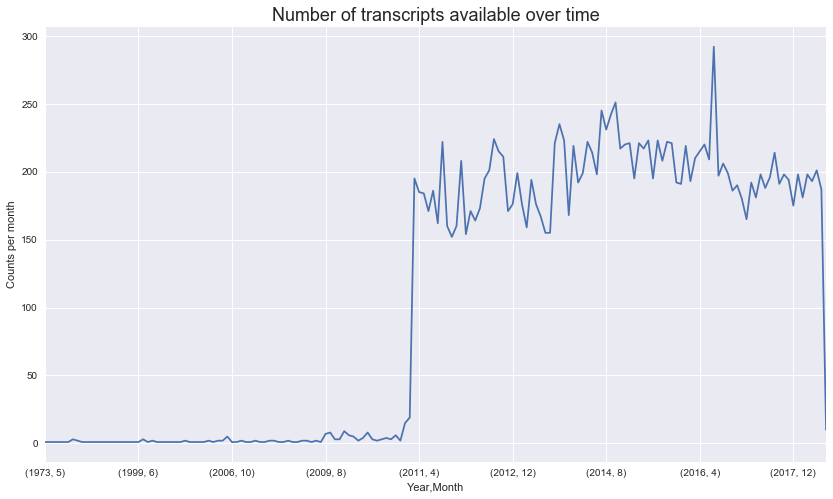

In [9]:
plt.figure(figsize=(14, 8))
plt.title("Number of transcripts available over time", fontsize=18)

(df
    .assign(n=0)
    .groupby(["Year", "Month"])
    .n
    .apply(len)
    .sort_index()
         ).plot().set(ylabel="Counts per month");

<a id="earliest_interview"></a>

### [^](#toc) Earliest interview

I think it's amazing just looking back 7 years.  So much has changed, but in another sense, not much has changed.

The earliest mention of Donald Trump is in 2011 when he was demanding Obama for his birth certificate.  During that segment he is considering running for office. ([link](https://www.pbs.org/newshour/show/with-birth-certificate-release-obama-urges-shift-in-national-dialogue)).  This is tangetial, but this [clip](https://www.pbs.org/newshour/show/with-birth-certificate-release-obama-urges-shift-in-national-dialogue) also features PBS' Jim Lehrer 40 years earlier.

The earliest mention of Bernie Sanders is him weighing in on the 2011 Debt Ceiling negotitions ([link](https://www.pbs.org/newshour/show/debt-deal-stalemate-spills-into-weekend-for-obama-congress)).  He warns that the burden will fall on the working class.

In [10]:
# {x for x in set.union(*df.Speakers) if "BEZOS" in x}

### These are just examples
pois = {0: "BERNIE SANDERS",
        1: "VLADIMIR PUTIN",
        2: "DONALD TRUMP",
        3: "JUDY WOODRUFF",
        4: "BEN CARSON",
        5: "STEPHEN COLBERT",
        6: "HILLARY CLINTON",
        7: "JOHN F. KENNEDY",
        8: "ANGELA MERKEL",
        9: "JEFF BEZOS",
        10: "XI JINPING"
}

poi = pois[8]

print("Showing results for:", poi)
df[df.Speakers.map(lambda x: poi in x)]

Showing results for: ANGELA MERKEL


,URL,Story,Date,Title,Transcript,Speakers,Number of Comments,Timezone,Year,Month
203,https://www.pbs.org/newshour/show/news-wrap-gu...,"In other news Wednesday, a gunman killed two U...",2011-03-02 07:50:00,"News Wrap: Gunman Kills 2 U.S. Airmen, Wounds ...","[[HARI SREENIVASAN, [ A gunman shot four U.S. ...","{HARRY REID, BEN BERNANKE, JOHN BOEHNER, BARAC...",0.0,EDT,2011,3
275,https://www.pbs.org/newshour/show/japan-s-disa...,The nuclear crisis in Japan is raising questio...,2011-03-16 08:09:00,Japan’s Nuclear Crisis Raises Energy Questions...,"[[JUDY WOODRUFF, [ The nuclear crisis in Japan...","{KWAME HOLMAN, STEVEN CHU, SETH MCKINNEY, JORD...",0.0,EDT,2011,3
289,https://www.pbs.org/newshour/show/ireland-s-ne...,Margaret Warner reports on Ireland's debt woes...,2011-03-17 08:42:00,Ireland’s New Leader Wrestles With Lingering D...,"[[JEFFREY BROWN, [ Next tonight, Europe’s debt...","{JEFFREY BROWN, ENDA KENNY, BARACK OBAMA, MARG...",0.0,EDT,2011,3
658,https://www.pbs.org/newshour/show/imf-chief-st...,"In New York, Judge Melissa Jackson denied IMF ...",2011-05-16 06:16:00,IMF Chief Strauss-Kahn Denied $1 Million Bail ...,"[[GWEN IFILL, [ An arrest in New York that is ...","{BENOIT HAMON, MELISSA JACKSON, MAN, GIORGOS D...",0.0,EDT,2011,5
744,https://www.pbs.org/newshour/show/news-wrap-ye...,Government forces in Yemen went on the offensi...,2011-05-30 04:30:00,News Wrap: Yemeni Forces Try to Retake Militan...,"[[KWAME HOLMAN, [ Government forces in Yemen w...","{KWAME HOLMAN, REBECCA HAMILTON, ANGELA MERKEL}",0.0,EDT,2011,5
1835,https://www.pbs.org/newshour/show/war-torn-afg...,After twin suicide bombings killed dozens of S...,2011-12-06 06:02:00,War-Torn Afghanistan Suffers Worst Sectarian V...,"[[JUDY WOODRUFF, [ A suicide attacker killed 5...","{YOUSUF RAZA GILANI, MOHAMMAD AYUB SALANGI, JU...",0.0,EDT,2011,12
2935,https://www.pbs.org/newshour/show/greece-s-res...,World leaders reacted with cautious optimism a...,2012-06-18 06:03:00,Greece’s Respite Met With Cautious Optimism,"[[JEFFREY BROWN, [ Europe cleared a major hurd...","{KOSTAS TSIKRIKAS, PANOS GIANNAKOPOULOS, ANTON...",0.0,EDT,2012,6
3564,https://www.pbs.org/newshour/show/news-wrap-fa...,"In other news Wednesday, two fires at factorie...",2012-09-12 06:16:00,News Wrap: Industrial Factory Fires in Pakista...,"[[HARI SREENIVASAN, [ Two industrial fires in ...","{ANGELA MERKEL, HARI SREENIVASAN}",0.0,EDT,2012,9
3747,https://www.pbs.org/newshour/show/news-wrap-ac...,Girls’ education activist Malala Yousufzai was...,2012-10-09 06:11:00,"News Wrap: Activist for Girls’ Education, 14, ...","[[HARI SREENIVASAN, [ Questions swirled again ...","{JAMES MATES, ERIC HOLDER, ANGELA MERKEL, HARI...",0.0,EDT,2012,10
6001,https://www.pbs.org/newshour/show/merkel-u-s-s...,"At a European Union summit, German Chancellor ...",2013-10-24 06:10:00,Will fallout of ‘spying on friends’ allegation...,"[[GWEN IFILL, [ A usually fractured European U...","{MARGARET WARNER, LUKE BAKER, JAY CARNEY, GWEN...",0.0,EDT,2013,10


---
<a id="trends"></a>

# [^](#toc) Trends

<a id="topic_popularity"></a>

### [^](#toc) Topic Popularity

AttributeError: 'DataFrame' object has no attribute 'Transcript'

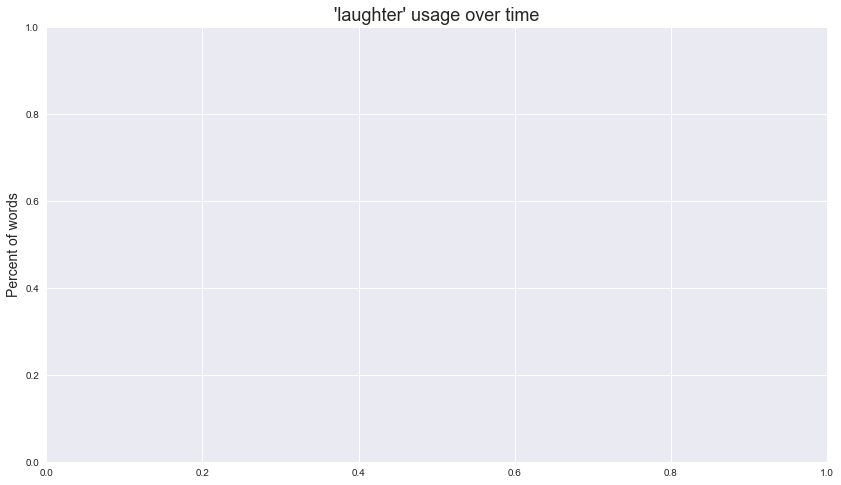

In [36]:
from collections import Counter

LIMIT_TIME = False

topics     = ["Obama", "Trump", "Clinton", "Immigration", "Congress", "Cuba", "laughter"]
topic      = topics[-1]

def topic_popularity(topic):
    def popularity_helper(transcript):
        transcript = list(map(lambda x: x[1][0], transcript))
        transcript = (" ".join(transcript).lower()).split(" ")
        N          = len(transcript)
        counts     = Counter(transcript)
        return (counts[topic.lower()] / N) * 100
    return popularity_helper

plt.figure(figsize=(14, 8))
plt.title(f"'{topic}' usage over time", fontsize=18)
plt.ylabel("Percent of words", fontsize=14)

df["Temp"] = (
                df[df.Transcript.map(lambda x: x != [])]
                    .Transcript
                    .map(topic_popularity(topic))
                )

if LIMIT_TIME:
    temp = df[df.Year > 2010]
else:
    temp = df

(temp
     .groupby(["Year", "Month"])
     .Temp
     .apply(np.mean)
).plot()

df.drop("Temp", axis=1, inplace=True)

---
<a id="movies"></a>

# [^](#toc) <u>Is News a Bad Movie?</u>

I want to see how political sentiment changes over time.  However that's hard to quantify, how do I train whether.

### What is double jeopardy?

It does feel very stupid training a model on movie reviews.  In addition, I'm using naive bayes and word frequency analysis which is stupid in itself.  Models like this don't understand sarcasm, different word meanings, or phrases.  However we should be okay.

<a id="load_movie"></a>

### [^](#toc) Load data

In [15]:
train = pd.read_feather("data/movie_train.csv")
test  = pd.read_feather("data/movie_test.csv")

In [16]:
# train_dir = "data/large-movie-reviews/train/"
# test_dir  = "data/large-movie-reviews/test/"

# train = pd.DataFrame(columns=["Text", "Sentiment"])
# test  = pd.DataFrame(columns=["Text", "Sentiment"])

# for df, path in ([train, train_dir], [test, test_dir]):
#     for sent in ("pos", "neg"):
#         for txt in tqdm(glob.glob(path + sent + "/*")):
#             txt = open(txt, "r")

#             review = txt.read()
#             df.loc[len(df)] = [review, sent]

#             txt.close()

# train.head()

<a id="feather_movies"></a>

### [^](#toc) Feather new Data Frame [REMOVE]

In [17]:
# train.to_feather("data/movie_train.csv")
# test.to_feather("data/movie_test.csv")

### Sentiment

In [18]:
train.Sentiment = train.Sentiment.map(lambda x: int(x == "pos"))
test.Sentiment  = test.Sentiment.map(lambda x: int(x == "pos"))

# Save memory space
train.Sentiment = train.Sentiment.astype(np.int8)
test.Sentiment  = test.Sentiment.astype(np.int8)

---
<a id="training"></a>


# [^](#toc) <u>Model training</u>

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

from nltk.stem import WordNetLemmatizer

lemm = WordNetLemmatizer()

class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [21]:
# Storing the entire training text in a list
text = list(train.Text.values)
# Calling our overwritten Count vectorizer
tf_vectorizer = LemmaCountVectorizer(max_df=0.95, 
                                     min_df=2,
                                     stop_words='english',
                                     decode_error='ignore')
tf = tf_vectorizer.fit_transform(text)

In [35]:
bad_words  = (">AAARGH!<", "<<<<<<<<<<<< <<<<<<<<<<<<<<<<<<<< <<<<<<<<<<<<<<<<<<<<<<<< <<<<<<<",
             "<grin>", "(comedy)", "(horror)", "(Mr. Director)", "<<<sigh>>>", ">.<",
             "<http://rogerebert.suntimes.com/apps/pbcs.dll/section?category=ANSWERMAN>")

html_words = ("<hr>", "<br /><br />", "<i>", "</i>", "<em>", "</em>", "<SPOILER>", "</SPOILER>",)

def clean_txt(txt, words):
    for word in words:
        txt = txt.replace(word, "")
    return txt

for txt in train.Text.values:
    txt = clean_txt(txt, bad_words)
    txt = clean_txt(txt, html_words)
    if "<" in txt and ">" in txt:
        print(txt)
        print()

> Contrary to most reviews I've read, I didn't feel this followed any of the other rock movies ("Spinal Tap", etc.) The story was more unique, although I feel most people wanted to see the "sex, drugs & rock and roll" vices that the band kept alluding to.> As an American, I knew a few of the actors - Spall, Connelly & Rea. Surprised to find out "Brian"/Bruce Robinson was in Zifferedi's (<sp?) classic "Romeo & Juliet". Guess I'll have to rent that next.> "THE FLAME STILL BURNS" - My wife, who hails from Mexico, didn't follow the English/British language too well, missed some of the jokes (which I dutifully explained) but she cried her eyes out at the concert scene. She loves the song so much now.> Funny that Amazon.com has the soundtrack for $30+usd when I bought the DVD in the bargain bin at Wal-Mart for $5.50usd. Price non-withstanding, I first saw this on late night cable and have been dying to find it ever since.

*** THIS CONTAINS MANY, MANY SPOILERS, NOT THAT IT MATTERS, SINCE EVE

In [22]:
feature_names = tf_vectorizer.get_feature_names()
count_vec = np.asarray(tf.sum(axis=0)).ravel()
zipped = list(zip(feature_names, count_vec))
x, y = (list(x) for x in zip(*sorted(zipped, key=lambda x: x[1], reverse=True)))
# Now I want to extract out on the top 15 and bottom 15 words
Y = np.concatenate([y[0:15], y[-16:-1]])
X = np.concatenate([x[0:15], x[-16:-1]])

# Plotting the Plot.ly plot for the Top 50 word frequencies
data = [go.Bar(
            x = x[0:50],
            y = y[0:50],
            marker= dict(colorscale='Jet',
                         color = y[0:50]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 Word frequencies after Preprocessing'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

# Plotting the Plot.ly plot for the Top 50 word frequencies
data = [go.Bar(
            x = x[-100:],
            y = y[-100:],
            marker= dict(colorscale='Portland',
                         color = y[-100:]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Bottom 100 Word frequencies after Preprocessing'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

### Are certain words associated with good or bad movies?

Look at articles with these words in their summary

In [ ]:
words = ["Obama", "Trump", "Clinton", "Immigration", "Science"]

### Do certain 

In [ ]:
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb